In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import re

In [2]:
import glob, os
import itertools
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
from shapely.geometry import LineString

In [38]:
import sys
import importlib


sys.path.insert(0, '..//local/bin')

importlib.reload(edgelist_creation)
import edgelist_creation
from edgelist_creation import *

#### Congress members csv: each row is a congress member from George Washington to Trump

In [14]:
members = pd.read_csv('../dataset/HSall_members.csv')
members.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0.0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,House,379,44,2.0,GA,4000,0.0,1.0,"BALDWIN, Abraham",...,1807.0,-0.165,-0.373,-28.55029,0.758,103.0,12.0,NaN,-0.429,-0.817
2,1,House,4854,44,1.0,GA,4000,0.0,1.0,"JACKSON, James",...,1806.0,-0.320,-0.181,-24.89986,0.776,98.0,9.0,NaN,-0.559,-0.052
3,1,House,6071,44,3.0,GA,4000,0.0,1.0,"MATHEWS, George",...,1812.0,-0.428,-0.317,-12.62728,0.880,99.0,2.0,NaN,-0.413,-0.232
4,1,House,1538,52,6.0,MD,5000,0.0,1.0,"CARROLL, Daniel",...,1796.0,0.116,-0.740,-23.47008,0.783,96.0,11.0,NaN,0.114,-0.779


#### Congress parties csv: we use it to map party_code with a party_name

In [8]:
party_codes = pd.read_csv('../dataset/HSall_parties.csv')
party_codes.head()

,congress,chamber,party_code,party_name,n_members,nominate_dim1_median,nominate_dim2_median,nominate_dim1_mean,nominate_dim2_mean
0,1,President,5000,Pro-Administration,1,NaN,NaN,NaN,NaN
1,1,House,4000,Anti-Administration,29,0.0180,0.0920,-0.024379,0.141931
2,1,House,5000,Pro-Administration,31,0.5760,0.0040,0.513161,-0.009484
3,1,Senate,4000,Anti-Administration,9,-0.2375,-0.2130,-0.239750,-0.044750
4,1,Senate,5000,Pro-Administration,20,0.4270,-0.3085,0.352050,-0.166200


#### example of a congressional vote csv. here we have all roll call votes of the 77th congress.

In [9]:
congress_77 = pd.read_csv('../dataset/download_votes_merged/congress_077.csv')
congress_77.head()

,bill_number,id,description,chamber,date,vote_desc,vote_result,congress,rollnumber,Peltzman,Clausen,name,party_short_name,icpsr,vote
0,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"ROOSEVELT, Franklin Delano",Democrat,99899,Abs
1,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"BOYKIN, Frank William",Democrat,937,Abs
2,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"GRANT, George McInvale",Democrat,3754,Abs
3,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"STEAGALL, Henry Bascom",Democrat,8858,Nay
4,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"HOBBS, Samuel Francis",Democrat,4471,Nay


#### in 2 years we have "just" 152 roll call votes
A roll call vote is when a board person casts a vote in favor or against a particular motion

In [10]:
len(set(congress_77['id']))

152

In [11]:
len(congress_77)

65610

  0%|          | 0/41 [00:00<?, ?it/s]

 78%|███████▊  | 32/41 [00:39<00:11,  1.25s/it]/home/leonardo/projects/USA_Congress_SigNet/notebooks/..//local/bin/edgelist_creation.py:20: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  res[congress] = len(set(pd.read_csv(csv)['id']))                                        # count the number of unique votes in the file and store it in a dictionary
100%|██████████| 41/41 [00:54<00:00,  1.33s/it]


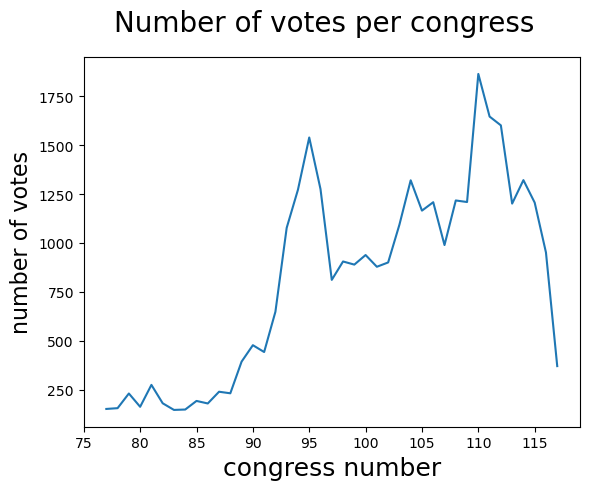

In [12]:
res = plot_votes_per_congress()

### add info to members dataframe

#### we create a dataframe that contains some information for every politician who has been in the US Congress for at least one time.
#### for example, we have a list of all the congresses he has been part of and all the parties he has been in.

In [23]:
members = create_members_df(members, party_codes)
members.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name
0,1,[82],[200],"AANDAHL, Fred George",ND,[Republican]
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,[Democrat]
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,[Whig]
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,[Democrat]
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"[Crawford Republican, Democrat-Republican]"


In [24]:
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()			# create a dictionary for the party names

### Check vote theme

#### in case we would use the topic of the vote, we have two categories: "Clausen categories" and "Peltzman categories"

In [25]:
set(congress_77['Clausen'])

{'Agriculture',
 'Civil Liberties',
 'Foreign and Defense Policy',
 'Government Management',
 'Miscellaneous Policy',
 'Social Welfare'}

In [26]:
set(congress_77['Peltzman'])

{'Budget General Interest',
 'Budget Special Interest',
 'D. C.',
 'Defense Policy Budget',
 'Defense Policy Resolutions',
 'Domestic Social Policy',
 'Foreign Policy Budget',
 'Indian Affairs',
 'Internal Organization',
 'Regulation General Interest',
 'Regulation Special Interest'}

Peltzmann Categories include two more categories: "Foreign Policy Resolutions" and "Government Organization" (see https://voteview.com/articles/issue_codes)

In [27]:
congress_77[['Peltzman', 'Clausen']].groupby('Clausen').apply(set)	

Clausen
Agriculture                   {Clausen, Peltzman}
Civil Liberties               {Clausen, Peltzman}
Foreign and Defense Policy    {Clausen, Peltzman}
Government Management         {Clausen, Peltzman}
Miscellaneous Policy          {Clausen, Peltzman}
Social Welfare                {Clausen, Peltzman}
dtype: object

In [28]:
pd.set_option('display.max_colwidth', None)
themes_df = congress_77[['Peltzman', 'Clausen']].groupby('Clausen').agg({'Peltzman': lambda x: list(set(x))})
themes_df

,Peltzman
Clausen,
Agriculture,"[Budget Special Interest, Regulation General Interest, Regulation Special Interest]"
Civil Liberties,[Domestic Social Policy]
Foreign and Defense Policy,"[D. C., Defense Policy Resolutions, Defense Policy Budget, Foreign Policy Budget]"
Government Management,"[Regulation General Interest, Budget Special Interest, Indian Affairs, Regulation Special Interest, Domestic Social Policy, D. C., Internal Organization, Budget General Interest]"
Miscellaneous Policy,[Internal Organization]
Social Welfare,"[Regulation Special Interest, Domestic Social Policy, D. C.]"


### Create the edgelist

#### how to create an edgelist from a congress vote csv.

In [37]:
edgelist = edgelist_from_congress(congress_77, members_party_dict)
edgelist.head()

  0%|          | 0/152 [00:00<?, ?it/s]

100%|██████████| 152/152 [00:34<00:00,  4.39it/s]


,source,target,weight,count,party,votes_togheter,perc
0,100,121,-1,72,out,131,0.549618
1,100,121,1,59,out,131,0.450382
2,100,158,-1,61,out,126,0.484127
3,100,158,1,65,out,126,0.515873
4,100,165,-1,14,in,123,0.113821


### Filter edges

#### In order to keep only the edges that represent a clear positive or negative relationship between two politicians, two thresholds are computed for each Congress: one for the positive edges and one for the negative edges. The threshold for the positive edges is defined as the crossing point between the kernel density estimation (KDE) of the percentage of votes in agreement of the “intra-party” and “inter-party” edges. The threshold for negative edges is computed similarly.

#### positive edges threshold

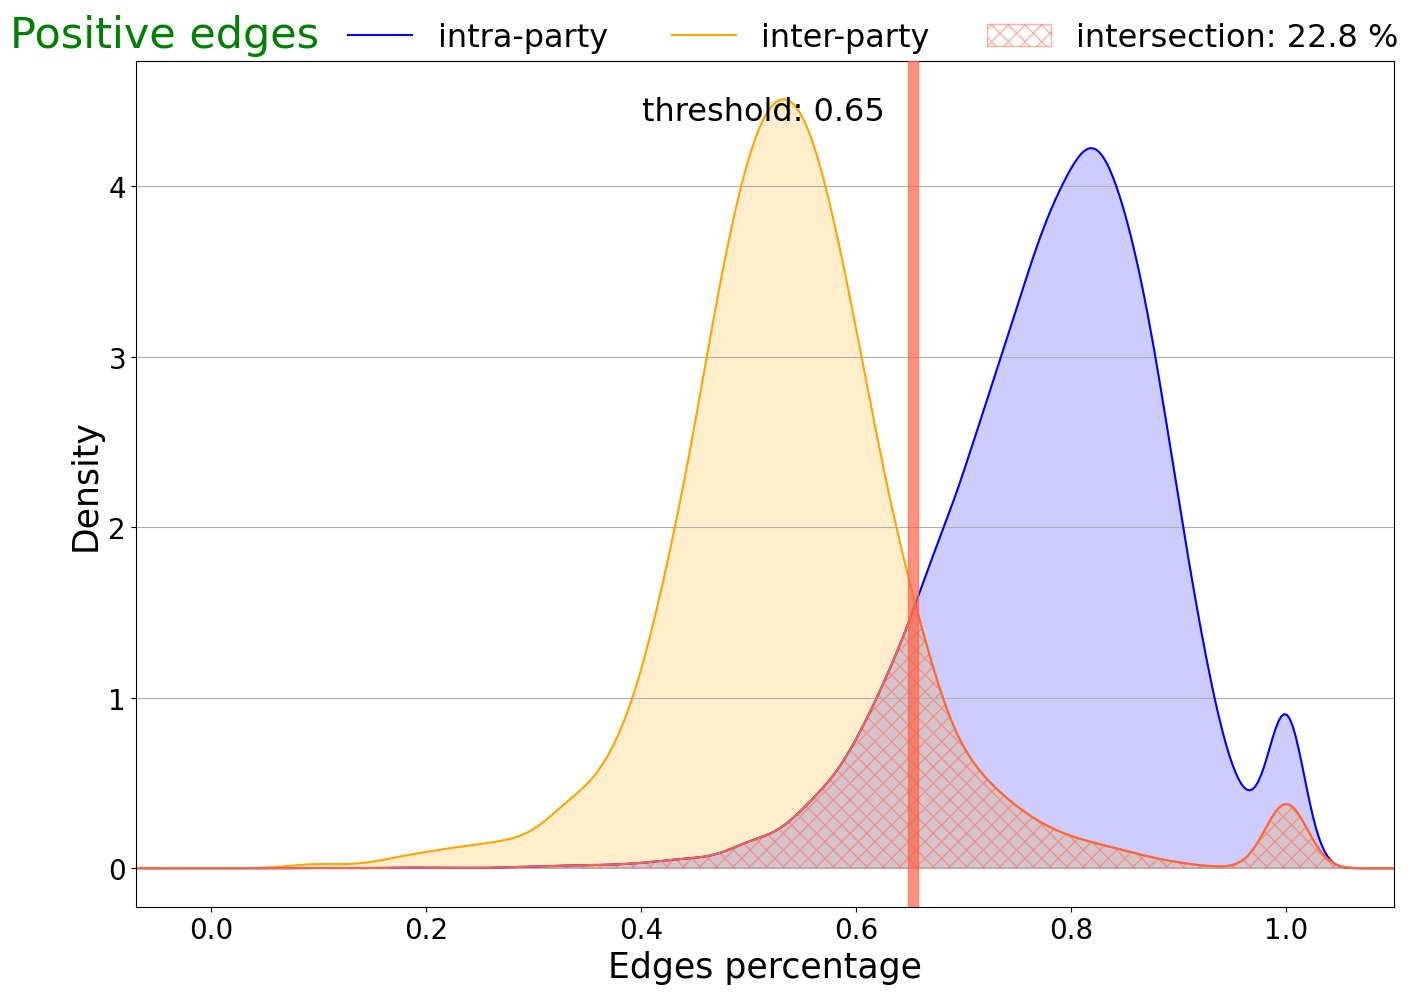

In [40]:
threshold_pos, area_inters_x_pos = plot_kde(edgelist, 1)

In [42]:
print('threshold_pos: ', threshold_pos)
print('area_inters_x_pos: ', area_inters_x_pos)


threshold_pos:  0.652767072606752
area_inters_x_pos:  0.2276626574429979


#### negative edges threshold

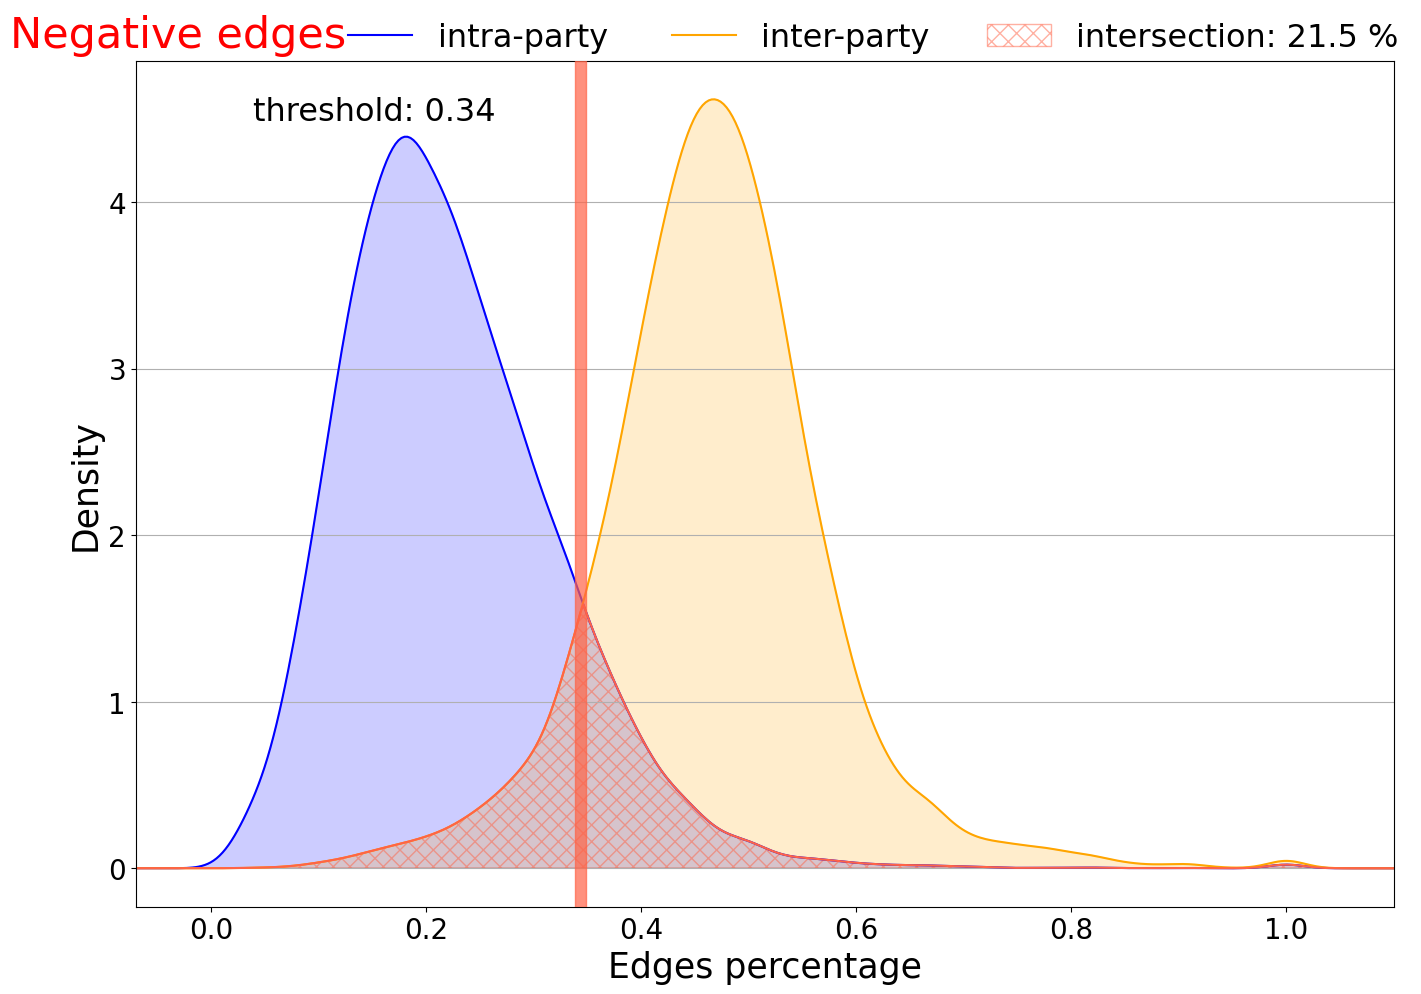

In [36]:
threshold_neg, area_inters_x_neg = plot_kde(edgelist, -1, str(77))

In [43]:
print('threshold_neg: ', threshold_neg)
print('area_inters_x_neg: ', area_inters_x_neg)

threshold_neg:  0.3435054016078133
area_inters_x_neg:  0.21470123767797067


#### Apply thresholds 

In [60]:
len(edgelist)

201069

In [61]:
filtered_edgelist = pd.concat([
        edgelist[(edgelist['weight']==1)&(edgelist['perc']>=threshold_pos)],
        edgelist[(edgelist['weight']==-1)&(edgelist['perc']>=threshold_neg)]

])

filtered_edgelist

#### For each pair of nodes of Gc we compute the percentage of votes in agreement (p+) as the weight of the positive edges divided by the sum of the weights of the positive and negative edges (see equations 9). The same process is used to compute the percentage of disagreements (p−).
#### In the edgelist dataframe it's called edgelist['perc'] 

In [64]:
len(filtered_edgelist)

102625

In [65]:
filtered_edgelist = filtered_edgelist.sort_values(['source', 'target', 'perc'], ascending = False).drop_duplicates(['source', 'target'], keep='first').reset_index(drop=True)

In [67]:
len(filtered_edgelist)

102029